<a href="https://colab.research.google.com/github/BERUK-GGG/DEEPLEARN-ING/blob/main/lab4_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from pandas import DataFrame

## Create a bagging ensemble


In [3]:
# load dataset
X, y = make_blobs(n_samples=1000, centers=5, n_features=2, cluster_std=2, random_state=2)

type(X)

numpy.ndarray

In [4]:
#convert into pandas dataframe

df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df.head()


,x,y,label
0,-0.556972,-4.843934,2
1,-3.115828,-5.311301,4
2,-6.344263,1.273859,3
3,5.967619,-2.196274,1
4,-2.510914,-1.569808,2


In [6]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(y)
print(y)
print(y.shape)

[[[1. 0.]
  [1. 0.]
  [0. 1.]
  [1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [0. 1.]]

 [[1. 0.]
  [1. 0.]
  [1. 0.]
  [0. 1.]
  [1. 0.]]

 ...

 [[0. 1.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [0. 1.]]

 [[1. 0.]
  [1. 0.]
  [0. 1.]
  [1. 0.]
  [1. 0.]]]
(1000, 5, 2)


In [11]:
# weak model

from tensorflow import keras


def evaluateModel( train_x, train_y , test_x, test_y):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(50, input_dim=2, activation='relu'))
    model.add(keras.layers.Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(train_x, train_y, epochs=50, verbose=0)

    test_loss, test_acc = model.evaluate(test_x, test_y, verbose=0)

    return model, test_acc


In [12]:
# train and test split
dataX, datay = make_blobs(n_samples=55000, centers=5, n_features=2, cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]

'''print(train_X.shape, test_X.shape)
print(train_y.shape, test_y.shape)

train_y, test_y = to_categorical(train_y), to_categorical(test_y)
print(train_y.shape, test_y.shape)'''

'print(train_X.shape, test_X.shape)\nprint(train_y.shape, test_y.shape)\n\ntrain_y, test_y = to_categorical(train_y), to_categorical(test_y)\nprint(train_y.shape, test_y.shape)'

In [14]:
from sklearn.utils import resample

n = 1
n_splits = 10
scores, members = list(), list()
for m in range(n_splits):

    # select indexes
    ix = [i for i in range(len(X))]
    train_ix = resample(ix, replace=True, n_samples=4500)
    test_ix = [x for x in ix if x not in train_ix]

    # select data
    trainX, trainy = X[train_ix], y[train_ix]
    testX, testy = X[test_ix], y[test_ix]

    #to_catogorical

    trainy,testy = to_categorical(trainy), to_categorical(testy)

    # evaluate model
    model, test_acc = evaluateModel(trainX, trainy, testX, testy)
    print(f'{n}: test_acc: {test_acc:.2f}')
    n +=1
    scores.append(test_acc)
    members.append(model)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1: test_acc: 0.76
2: test_acc: 0.77
3: test_acc: 0.77
4: test_acc: 0.77
5: test_acc: 0.76
6: test_acc: 0.78
7: test_acc: 0.77
8: test_acc: 0.78
9: test_acc: 0.76
10: test_acc: 0.77


In [15]:
import numpy as np

print(f'Estimated Accuracy {np.mean(scores): .2f} ({np.std(scores): .3f})')

Estimated Accuracy  0.77 ( 0.007)


Evaluate different numbers of ensembles


In [16]:
#ensamble prediction

def ensemblePredictions(members, testX):

    # make predictions
    yhats = [model.predict(testX) for model in members]

    yhats = np.array(yhats)

    # sum across ensemble members
    summed = np.sum(yhats, axis=0)

    # argmax across classes
    result = np.argmax(summed, axis=1)

    # return the result
    return result
    pass


In [17]:
from sklearn.metrics import accuracy_score

#evaluate a specific member
def evaluateNMembers(members, n_members, testX, testy):

    # select a subset of members
    subset = members[:n_members]

    # make prediction
    yhat = ensemblePredictions(subset, testX)

    # calculate accuracy
    return accuracy_score(testy, yhat)
    pass

Evaluate different numbers of ensembles.


In [18]:
single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
    ensemble_score = evaluateNMembers(members, i, newX, newy)

    newy_enc = to_categorical(newy)

    _, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)

    print(f'{i}: single={single_score: .2f}, ensemble={ensemble_score: .2f}')

    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)
    pass

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1: single= 0.76, ensemble= 0.76
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step
2: single= 0.76, ensemble= 0.76
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step
3: single= 0.76, ensemble= 0.76
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 977us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step
4: single= 0.76, ensemble= 0.76
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step
5: single= 0.76, ensemble= 0.76
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 80

In [28]:
for i in range(1, 11):
  print( f"{i}: ensemble_score:{ensemble_scores[i-1]}, single_score:{single_scores[i-1]}")

1: ensemble_score:0.7588, single_score:0.7588000297546387
2: ensemble_score:0.75874, single_score:0.7575600147247314
3: ensemble_score:0.7586, single_score:0.7591400146484375
4: ensemble_score:0.759, single_score:0.7584599852561951
5: ensemble_score:0.75944, single_score:0.7580400109291077
6: ensemble_score:0.75934, single_score:0.7577000260353088
7: ensemble_score:0.7595, single_score:0.758899986743927
8: ensemble_score:0.75902, single_score:0.7555599808692932
9: ensemble_score:0.75904, single_score:0.7587599754333496
10: ensemble_score:0.75878, single_score:0.7575600147247314


Plot score vs number of ensemble members


Accuracy  0.76 ( 0.001)


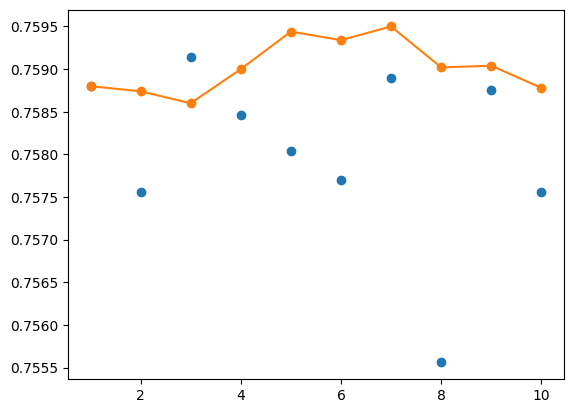

In [19]:
print(f'Accuracy {np.mean(single_scores): .2f} ({np.std(single_scores): .3f})')
x_axis = [i for i in range(1, n_splits+1)]
plt.plot(x_axis, single_scores, marker='o', linestyle='None')
plt.plot(x_axis, ensemble_scores, marker='o')
plt.show()